In [83]:
import datetime as dt

from glmnet import elastic_net, glmnet

import sklearn
import sklearn.linear_model

import numpy as np
import yatsm
import patsy

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Setup

In [84]:
cfg = yatsm.config_parser.parse_config_file('../../examples/p022r049_example.yaml')
df = yatsm.utils.csvfile_to_dataframe(cfg['dataset']['input_file'])

Y = yatsm.reader.read_pixel_timeseries(df['filename'], 50, 50)

In [85]:
from yatsm.regression.transforms import harm

model = '1 + x + harm(x, 1)'
X = patsy.dmatrix(model, {'x': df['date']})

In [86]:
mask = np.in1d(Y[-1, :], [0, 1])

Y = Y[:-1, mask]
X = X[mask, :]

In [87]:
sklearn_yhat = sklearn.linear_model.Lasso(alpha=20).fit(X, Y[4, :]).predict(X)
glmnet_yhat = yatsm.regression.glmnet_fit.GLMLasso(alpha=20).fit(X, Y[4, :]).predict(X)

## Validation

<IPython.core.display.Javascript object>


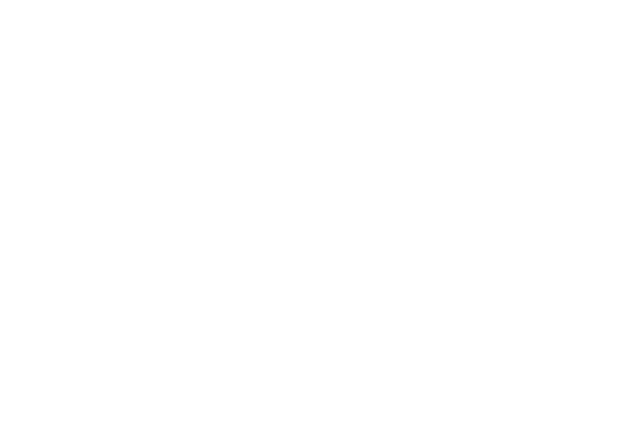

In [88]:
%matplotlib nbagg

plt.plot(X[:, 1], sklearn_yhat, 'ro', label='sklearn')
plt.plot(X[:, 1], glmnet_yhat, 'bo', label='glmnet')

<IPython.core.display.Javascript object>


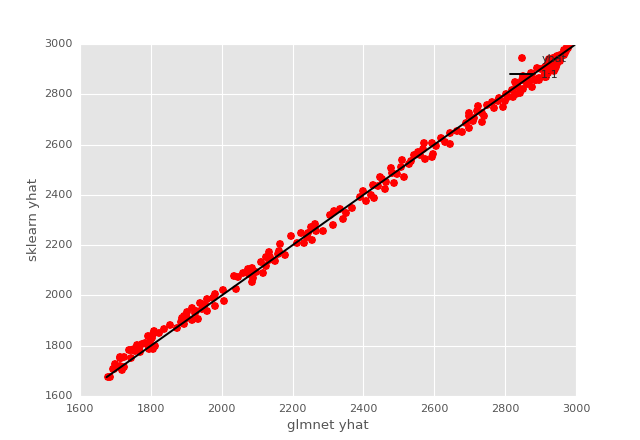

In [89]:
%matplotlib nbagg

plt.plot(glmnet_yhat, sklearn_yhat, 'ro', label='yhat')
plt.xlabel('glmnet yhat')
plt.ylabel('sklearn yhat')


_min, _max = min(glmnet_yhat.min(), sklearn_yhat.min()), max(glmnet_yhat.max(), sklearn_yhat.max())
plt.plot([_min, _max], [_min, _max], 'k-', label='1:1')
plt.legend()

In [90]:
def rmse(y, yhat):
    return ((y - yhat) ** 2).mean(axis=0) ** 0.5

In [91]:
print('sklearn RMSE: {}'.format(rmse(Y[4, :], sklearn_yhat)))
print('glmnet RMSE: {}'.format(rmse(Y[4, :], glmnet_yhat)))

sklearn RMSE: 426.725010472
glmnet RMSE: 426.120464173


## Benchmark

In [92]:
lasso = sklearn.linear_model.Lasso(alpha=20, warm_start=False)
%timeit -r 10 lasso.fit(X, Y[4, :])

10000 loops, best of 10: 152 µs per loop


In [93]:
lasso = sklearn.linear_model.Lasso(alpha=20, warm_start=True)
%timeit -r 10 lasso.fit(X, Y[4, :])

10000 loops, best of 10: 151 µs per loop


In [94]:
lasso = yatsm.regression.glmnet_fit.GLMLasso(alpha=20)
%timeit -r 10 lasso.fit(X, Y[4, :])

The slowest run took 4.05 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 10: 46.5 µs per loop


In [95]:
lasso = sklearn.linear_model.Lasso(alpha=20, warm_start=True, copy_X=False)
%timeit lasso.fit(X, Y[4, :])

10000 loops, best of 3: 150 µs per loop


In [96]:
alphas = np.linspace(0.001, 35, 25)

lassocv = sklearn.linear_model.LassoCV(alphas=alphas)
%timeit lassocv.fit(X, Y[4, :])

100 loops, best of 3: 3.91 ms per loop


In [97]:
alphas = np.linspace(0.001, 35, 50)

lassocv = sklearn.linear_model.LassoCV(alphas=alphas)
%timeit lassocv.fit(X, Y[4, :])

100 loops, best of 3: 5.98 ms per loop


In [98]:
alphas = np.linspace(0.001, 35, 100)

lassocv = sklearn.linear_model.LassoCV(alphas=alphas)
%timeit lassocv.fit(X, Y[4, :])

100 loops, best of 3: 10.1 ms per loop
